# Project - Outfit Assistant

In [47]:
# imports

import os
import requests
import json
from typing import List
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from IPython.display import Markdown, display, update_display
from openai import OpenAI
import gradio as gr
import base64
from io import BytesIO
from PIL import Image

In [48]:
# Initialization

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
weather_api_key = os.getenv('WEATHER_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("Weather API Key not set")
    
if weather_api_key:
    print(f"Weather API Key exists and begins {weather_api_key[:4]}")
else:
    print("Weather API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-
Weather API Key exists and begins c037


In [49]:
system_message = "You are a helpful outfit assistant that provides real-time weather information"
system_message += "Give short, courteous answers, no more than 2 sentence. "
system_message += "Always be accurate. If you don't know the real-time weather information, say so."


In [50]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7883

To create a public link, set `share=True` in `launch()`.


### Tool for weather information

In [51]:
# Let's start by making a useful function


def get_forecast(city):
    """
    Fetches the current weather forecast for the given city in both Celsius and Fahrenheit.

    Args:
        city (str): Name of the city to get the forecast for.

    Returns:
        string containing the temperature in Celsius and Fahrenheit.
    """
    print(f'Tool get_forecast called for {city}')
    
    # Replace 'your_api_key' with your actual OpenWeatherMap API key
    api_key = weather_api_key
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        data = response.json()

        # Extract temperature in Celsius
        temp_celsius = data['main']['temp']

        # Convert temperature to Fahrenheit
        temp_fahrenheit = (temp_celsius * 9/5) + 32

        return f"The temperature in {city} is {round(temp_celsius, 2)}°C ({round(temp_fahrenheit, 2)}°F)."

    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
            return f"Unknown location: '{city}'. Please check the location name and try again."
    
    except requests.exceptions.RequestException:
        return f"Unable to retrieve weather for '{city}'. Please check the location name."
    
    except KeyError:
        return f"Unable to retrieve weather details for '{city}'. Please verify the location."

In [59]:
get_forecast("Bogota")

Tool get_forecast called for Bogota


'The temperature in Bogota is 16.73°C (62.11°F).'

In [53]:
# There's a particular dictionary structure that's required to describe our function:

forecast_function = {
    "name": "get_forecast",
    "description": "Call this whenever you need to know real-time weather of a City, for example when user asks 'How is the weather today','What should I wear today', 'Help me with my outfit'",
    "parameters": {
        "type": "object",
        "properties": {
            "forecast_city": {
                "type": "string",
                "description": "The current forecast of the City that users want to check",
            },
        },
        "required": ["forecast_city"],
        "additionalProperties": False
    }
}

In [54]:
tools = [{"type": "function", "function": forecast_function}]

In [55]:
system_message += "If you have the real-time weather information, provide the information to the user, then ask if they would like an outfit recommendation"
system_message += "If user say yes for an outfit recomendation, kindly ask for they gender, age and if there is a color preference to tailor the outfit sugestion"
system_message += "If user provides color preference, provide color suggestion of each item based on matchin color pallete and include a short rephrased version of user profile gender, age, color preference."
system_message += "Always be accurate. Always consider the ideal outdoor temperature range for human confort and minimal physiological stress is generally between 20-22°C (68-72°F)"
system_message += "For example:'User: what is the weather today?, Assistant: Could you please confirm your City?, User: I am in Chicago, Assitant:It's currently -3.2°C (26.2°F) in Chicago. Would you like a outfit recommendation? ,User: Yes please, Assitant:Could you please confirm your gender, age, and color preferences?, User: I am a women 36 years old and I like dark green color, Assistant:It's currently -3.2°C (26.2°F) in Chicago, so I recommend dressing warmly in layers. For a 36-year-old woman, that love dark green, I recommend  a warm dark green coat pair it with earthy tones like beige or tan for pants, a white or cream shirt, and brown shoes. For accessories, gold or brass tones would complement"


### Testing Weather tool

In [56]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    # If a tool call is needed, handle it and get a new response
    if response.choices[0].finish_reason=="tool_calls":
        
        tool_message = response.choices[0].message
        tool_response = handle_tool_call(tool_message)
        
        # Add tool call and its response to messages
        messages.append(tool_message)
        messages.append(tool_response)
        
        # Get final response after tool call
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [57]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('forecast_city')
    forecast = get_forecast(city)
    response = {
        "role": "tool",
        "content": json.dumps({"forecast_city": city,"forecast": forecast}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response

In [58]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7884

To create a public link, set `share=True` in `launch()`.


Tool get_forecast called for Bogota


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4c - don't go crazy with images!

In [124]:
def artist(outfit_goal):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"A colorful fashion outfit illustration. Adjust the User: gender, age, and color scheme for the clothing and accessories as described: {outfit_goal}, do not add weather nor city information in the image. Fashion sketch style.",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

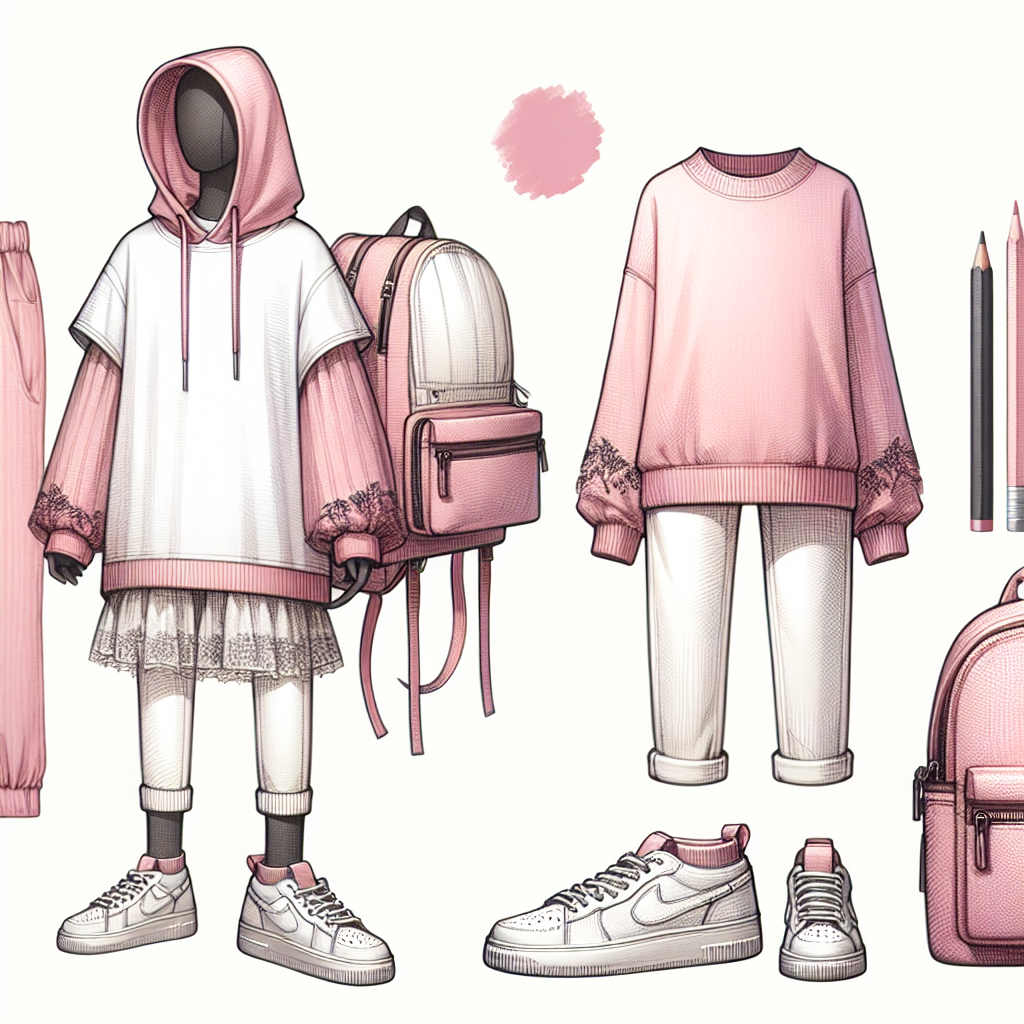

Tool get_forecast called for Caracas
Tool get_forecast called for Chicago


In [125]:
image = artist("It's currently 16.73°C (62.11°F) in Bogotá, so I recommend dressing in layers for comfort. For a 15-year-old girl who likes pink, I suggest a light pink hoodie, paired with gray or white jeans, a white t-shirt underneath, and pink sneakers. Accessories like a light pink backpack would complete the look perfectly!")
display(image)

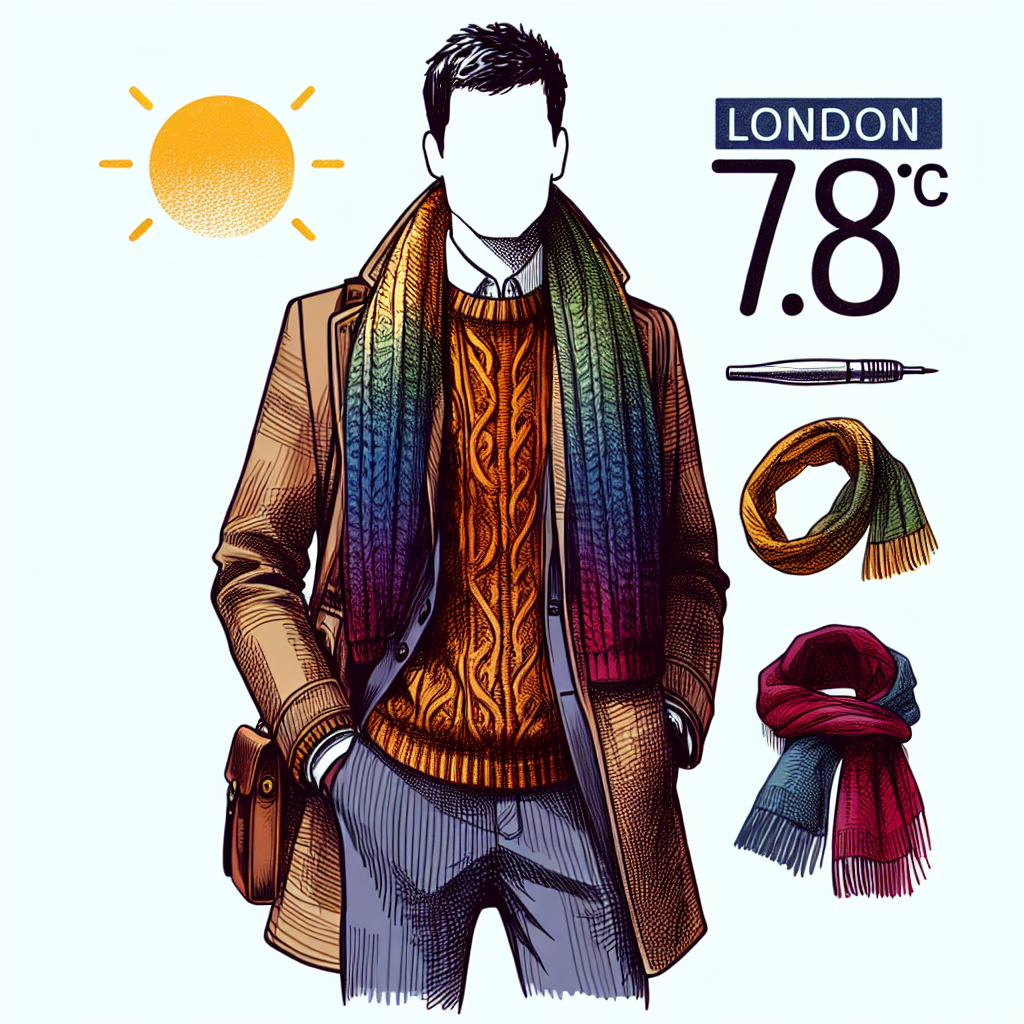

In [28]:
image = artist("Today in London, it's about 7.8°C (45.9°F). I recommend wearing a warm coat, and consider layering with a sweater and scarf for added comfort.")
display(image)

In [63]:
system_message += "Only after final outfit recommendation, You could ask the user if they would like an image of the final outfit"
system_message += "If user responds they do not want an image, do nothing."
system_message += "If user responds they want an image of the recommended outfit, check if you have the tools to create images. Always be accurate. If you don't have the tool, say so."


In [64]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.


Tool get_forecast called for New York


# Our Agent Framework

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities


### Testing Tool calling Artist agent

In [75]:
## New Tool that manages an agent

In [83]:
def get_image(outfit_goal):
    image = artist(outfit_goal)
    return image
    

In [90]:
image_function = {
    "name": "get_image",
    "description": "Call this whenever you need to create image of users outfit recommendation, for example when Assistant: Would you like an image of the final outfit?, User: Yes please",
    "parameters": {
        "type": "object",
        "properties": {
            "outfit_description": {
                "type": "string",
                "description": "The outfit suggested by the assistant that will be passed to the agent Artist",
            },
        },
        "required": ["outfit_description"],
        "additionalProperties": False
    }
}

In [91]:
tools = [{"type":"function","function":image_function}]

In [92]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":

        
        
         # If a tool call is needed, handle it and get a new response
        tool_message = response.choices[0].message
        #tool_response, city = handle_tool_call(tool_message)
        tool_result = handle_tool_call(tool_message)

        if tool_result:
            image , tool_response = tool_result

            # Add tool call and its response to messages
            messages.append(tool_message)
            messages.append(tool_response)

            # Get final response after tool call
            response = openai.chat.completions.create(model=MODEL, messages=messages)
     
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    #talker(reply)
    
    return history, image

In [95]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):

    if not message.tool_calls:
        return None
    
    tool_call = message.tool_calls[0]
    
    #parse arguments safetly

    try:
        arguments = json.loads(tool_call.function.arguments)
        outfit_description = arguments.get('outfit_description')

        #validate outfit description
        if not outfit_description:
            return None
        #generate image
        image = get_image(outfit_description)

        tool_response ={
            "role": "tool",
            "content": json.dumps({"image_generated": "success"}),
            "tool_call_id": tool_call.id
        }

        return image, tool_response

    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error processing tool call: {e}")
        return None

 
    

In [96]:
# More involved Gradio:

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch()

* Running on local URL:  http://127.0.0.1:7888

To create a public link, set `share=True` in `launch()`.


### Multi tool + agent

In [128]:
tools = [{"type": "function", "function": forecast_function},{"type":"function","function":image_function}]

In [129]:
# def chat(history):
#     messages = [{"role": "system", "content": system_message}] + history
#     response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
#     image = None
#     tool_response = None
    
#     if response.choices[0].finish_reason=="tool_calls":
#          # If a tool call is needed, handle it and get a new response
#         tool_message = response.choices[0].message
#         #tool_response, city = handle_tool_call(tool_message)
#         tool_result = handle_tool_call(tool_message)

#         #only append valid messages
#         if tool_message:
#             messages.append({"role":tool_message.role,"content":tool_message.content})
#         if tool_response:
#             messages.append(tool_response)
        
#         # Get final response after tool call
#         response = openai.chat.completions.create(model=MODEL, messages=messages, tools= tools)
     
#     reply = response.choices[0].message.content
#     history += [{"role":"assistant", "content":reply}]

#     # Comment out or delete the next line if you'd rather skip Audio for now..
#     #talker(reply)
    
#     return history, image

In [130]:
# # We have to write that function handle_tool_call that handle the two tools 

# def handle_tool_call(message):
       
#     if not message.tool_calls:
#         return None

#     # Placeholder for image and tool response
#     image = None
#     tool_response =None
    
#     #iterate through all tool calls in the message
#     for tool_call in message.tool_calls:
#         tool_name = tool_call.function.name #identify what tool was called

#         try:
#             arguments = json.loads(tool_call.function.arguments)            

#             if tool_name=="get_forecast": 
#                 #handles real time forecast
#                 city = arguments.get('forecast_city')
#                 forecast = get_forecast(city)
#                 response_content = {
#                     "role":"tool",
#                     "content":json.dumps({"forecast_city":city,"forecast":forecast}),
#                     "tool_call_id":tool_call.id
#                 }
#                 return None,tool_response
                

#             elif tool_name =="get_image": 
#                 #handles image generation
#                 outfit_description = arguments.get('outfit_description')
#                 image = get_image(outfit_description)
#                 response_content = {
#                     "role":"tool",
#                     "content":json.dumps({"image_generated":"success"}),
#                     "tool_call_id":tool_call.id
#                 }
#                 return image, tool_response

#         except (json.JSONDecodeError, KeyError) as e:
#             print(f"Error processing tool call: {e}")
#             return None

#     return None

In [134]:
def handle_tool_call(message):
    if not message.tool_calls:
        return None

    tool_call = message.tool_calls[0]
    try:
        arguments = json.loads(tool_call.function.arguments)            
        tool_name = tool_call.function.name

        if tool_name == "get_forecast":
            city = arguments.get('forecast_city')
            forecast = get_forecast(city)
            tool_response = {
                "role": "tool",
                "content": json.dumps({
                    "forecast_city": city,
                    "forecast": forecast
                }),
                "tool_call_id": tool_call.id
            }
            # as it only handle forecast returns None as image avoiding errors
            return None, tool_response

        elif tool_name == "get_image":
            outfit_description = arguments.get('outfit_description')
            image = get_image(outfit_description)
            tool_response = {
                "role": "tool",
                "content": json.dumps({"image_generated": "success"}),
                "tool_call_id": tool_call.id
            }
            #return the image and success as a response
            return image, tool_response

    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error processing tool call: {e}")
        return None

def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason == "tool_calls":
        tool_message = response.choices[0].message
        tool_result = handle_tool_call(tool_message)

        if tool_result:
            image, tool_response = tool_result
          
            messages.append({"role": "assistant", "content": tool_message.content or "",  #includes information about what tool was called and why. And prevents null context error
                             "tool_calls": tool_message.tool_calls})                      #preserves tool context (helping the model understand what actions were previosly called)
        
            messages.append(tool_response) #Adds the tool's response to the conversation # For weather: contains the forecast  # For image: contains confirmation of image generation
            response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]
    
    return history, image

In [132]:
# More involved Gradio:

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(share=True)

* Running on local URL:  http://127.0.0.1:7897
* Running on public URL: https://361f3233ad74bea2e5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Tool get_forecast called for Chicago
Tool get_forecast called for Miami
